# Introduction: Age, Gender, and Racial Bias in Facial Recognition Models
This notebook summarizes our findings for age, gender, and racial bias in open-source facial recognition models. For this study, we look specifically at the model from VGGFace ([this 2015 paper](http://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf) and [this 2017 paper](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/vggface2.pdf)) using the ResNet architecture. <br><br>
Deep facial recognition models represent faces in a high-dimensional embedding space. <a href='https://github.com/fellowship/identity/blob/master/exploration/bias_experiment/face_clusters.ipynb'>One of our explorations</a> looks at the variance of these embeddings across different facial expressions from identities with known race and gender labels. Surprisingly, we discovered that sex and race, but especially race classes, are seperable in the embedding space. A t-sne dimensional reduction visualizes this finding:
<img src='./imgs/tsne-face.png'>
While this is an interesting result, for our application we are concerned specifically about the model's error rate on the identification task across the race, gender, and age group classes. 

## The Experiment
To look directly at these error rates, we designed an experiment that scales the VGGFace model up to the magnitude of the classification task in the first VGGFace paper: a 2,620-way classification problem where each class is a unique individual. We do not train or fine-tune any of the pre-trained layers in the model; we only train the classification head. After the model converges, we test its performance and measure the error rate. Details on the implimentation of this experiment can be found in <a href='https://github.com/fellowship/identity/blob/master/exploration/bias_experiment/run_experiments.ipynb'>this notebook</a>.<br><br>
To achieve a sample size greater than 2,260, we resample from our hand-curated dataset and repeat the experiment several times. After repeating the experiment, we can compare error rates across these classes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom_test
from analyze_exp import make_age_group, get_confused_groups

In [2]:
ids = pd.read_csv('experiment_labels.csv')
results = pd.read_csv('results.csv')
ids['age_group'] = False
ids = ids.copy()

ids = make_age_group(ids, group=(18, 40))
ids = make_age_group(ids, group=(40, 200), name='41+')

mrgd = results.merge(ids, how='inner', right_on='unique_id', left_on='gt_id')[['gt_id', 'pred_id', 'sex', 'race', 'age', 'age_group']]
mrgd['correct'] = (mrgd.gt_id==mrgd.pred_id)

mrgd.age_group.value_counts()

18-40    48470
41+      48470
Name: age_group, dtype: int64

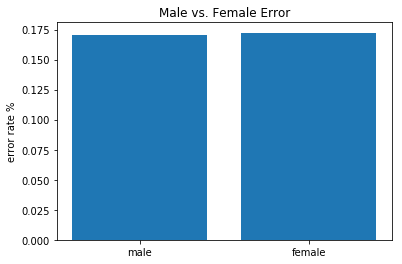

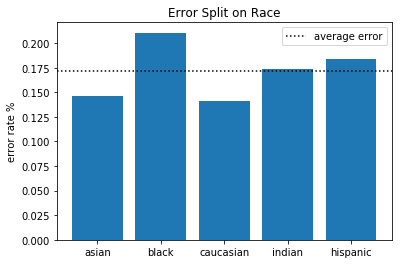

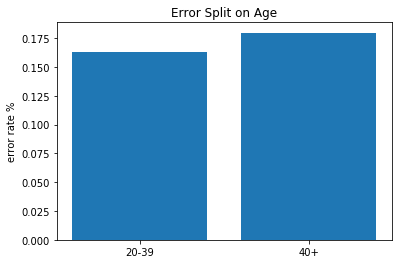

In [3]:
from analyze_exp import plot_sex_split, plot_race_split, plot_age_split
    
plot_sex_split(mrgd)
plot_race_split(mrgd)
plot_age_split(mrgd)

## Results
At a first glance, we see the most dramatic discrepancies in error rate between races. The asian and caucasian classes enjoy a below-average error rate, while black and hispanic have a higher rate. The indian class is slightly above the total mean error rate.<br><br>
We then use a statistical test to identify the most statistically significant groups in terms of their error rate vs. the expected error rate from the entire sample.

In [4]:
pred = results.merge(ids, how='inner', right_on='unique_id', left_on='pred_id')[['gt_id', 'pred_id', 'sex', 'race', 'age', 'age_group']]


mrgd['pred_sex'] = pred.sex
mrgd['pred_race'] = pred.race
mrgd['pred_age'] = pred.age
mrgd['pred_age_group'] = pred.age_group

In [5]:
print('total unique identities: ', len(mrgd.gt_id.unique()))

total unique identities:  18036


In [6]:
from analyze_exp import exhaust_splits

p_values = exhaust_splits(mrgd)
p_values.sort_values('p_corrected', ascending=True).head()

,p,p_corrected,sex,race,age_group
11,1.724155e-45,7.150358e-45,None,black,None
63,3.351722e-36,1.777439e-35,female,black,None
19,8.792023e-34,6.014811e-33,male,black,41+
70,8.792023e-34,6.014811e-33,female,black,41+
21,3.690290e-30,1.022397e-29,None,caucasian,None


We observe the smallest p-value (highest significance) for inviduals labeled black, followed by black females. We also see that asian males age 18-40 have a significantly _lower_ error rate than the total population.

Results for group:   black


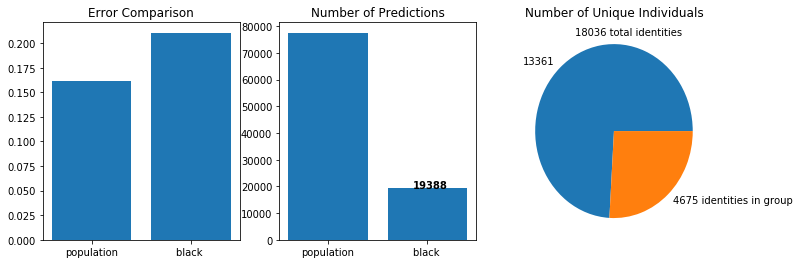

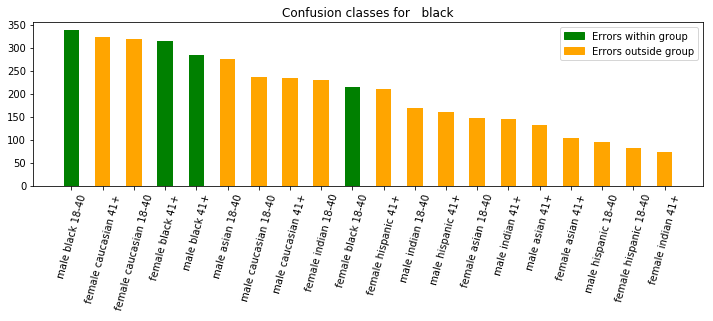

Binomial test for black:
expected accuracy:  0.829
observed accuracy:  0.789
p= 0.0
p corrected for number of individuals: 0.0


In [7]:
from analyze_exp import group_gambit

    
result = group_gambit(
    mrgd, 
    race='black'
)

Results for group:   female black


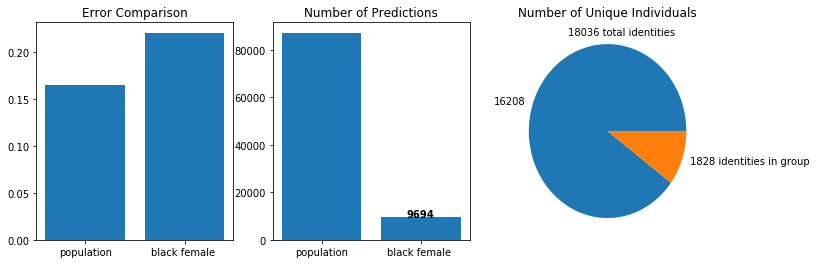

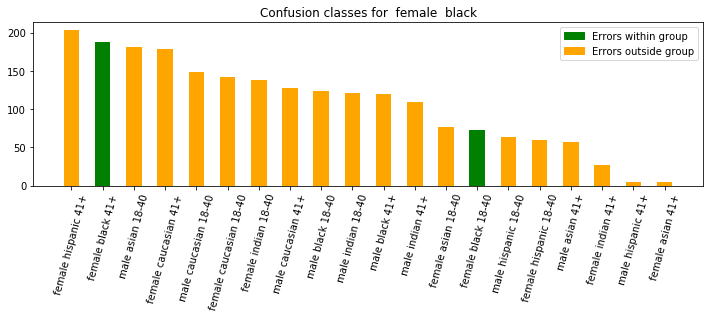

Binomial test for female black:
expected accuracy:  0.829
observed accuracy:  0.779
p= 0.0
p corrected for number of individuals: 0.0


In [8]:
result = group_gambit(
    mrgd, 
    sex='female', 
    race='black'
)

Results for group:   asian 18-40


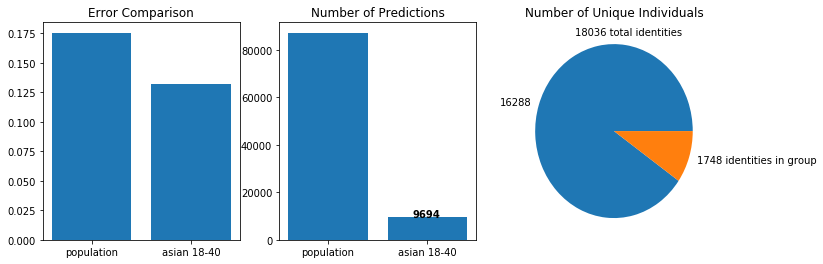

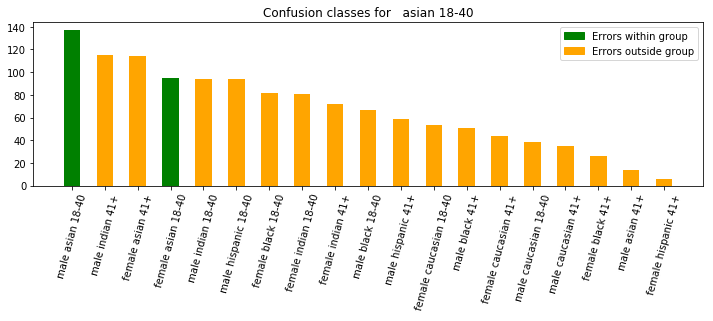

Binomial test for asian 18-40:
expected accuracy:  0.829
observed accuracy:  0.868
p= 0.0
p corrected for number of individuals: 0.0


In [9]:
result = group_gambit(
    mrgd,
    race='asian',
    age_group='18-40'
)

## Conclusion
This experiment gives evidence that we can expect a higher error rate from VGGFace on certain race classes; we might say the small p-values allow us to reject the null hypothesis: that race has no effect on the error rate of VGGFace identity classification.<br><br>
The results are interesting, but we are limited in this case by the lack of a strong dataset. To combat this, we curated and combined several datasets, taking extra care to remove duplicate identities. This is not to say that the dataset is perfect. We found that the UTKFace dataset, which makes up the majority of our curated set, contains some bad labels and repeated identities. To confirm these results, a better dataset is needed. To that end, we are anticipating <a href=''>the release of a novel facial recognition dataset designed specifically to combat this type of bias</a>.<br><br>
However, the results are strong enough to give our team some metrics as we work to improve the models we deploy.